In [46]:
# imports 
from stable_baselines3 import DQN, PPO
import gymnasium as gym
import gym_gridworlds
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [47]:
class OneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        n = env.observation_space.n
        self.observation_space = gym.spaces.Box(0, 1, (n,), dtype=np.float32)

    def observation(self, obs):
        v = np.zeros(self.observation_space.shape[0], dtype=np.float32)
        v[obs] = 1.0
        return v



In [48]:
# vars
env_name = "FourRooms-Original-13x13-v0"
save_model_name = "four_rooms"
distance_reward = True
no_stay = True
start_pos = None
random_goals = False

In [49]:
# make environment
env = gym.make(f"Gym-Gridworlds/{env_name}", 
               no_stay = no_stay, 
               distance_reward = distance_reward, 
               start_pos = start_pos, 
               random_goals = random_goals)

LOG_DIR = "log_dir/"
MODEL_DIR = "trained_models/"

# logging wrapper
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# wrap environment with logging wrapper for tensorboard
env = OneHotWrapper(env)
env = Monitor(env, LOG_DIR)

In [50]:
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=0.01,
    # buffer_size=50000,
    # learning_starts=1000,
    n_steps=64,
    batch_size=64,
    # tau=1.0,
    gamma=0.99,
    # train_freq=(1, "step"),
    # gradient_steps=1,
    # target_update_interval=250,
    exploration_fraction=0.01,
    # exploration_final_eps=0.05,
    verbose=1,
)
# model = PPO(
#     "MlpPolicy",
#     env,
#     n_steps = 100,
#     learning_rate=0.01,
#     gamma=0.999,
#     ent_coef=0.01,
#     verbose=1,
#     tensorboard_log=LOG_DIR
# )

Using cpu device
Wrapping the env in a DummyVecEnv.


In [51]:
# train model, progress bar w tdqm
print("--- Starting Training ---")
model.learn(total_timesteps=50000, progress_bar=False)
print("--- Training Finished ---")

--- Starting Training ---
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | -9.68    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2860     |
|    time_elapsed     | 0        |
|    total_timesteps  | 665      |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.238    |
|    n_updates        | 141      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 132      |
|    ep_rew_mean      | -5.64    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3042     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1059     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.187

In [52]:
model.save(f"trained_models/{save_model_name}")

In [53]:
eval_env = gym.make(f"Gym-Gridworlds/{env_name}", no_stay=no_stay, distance_reward=distance_reward)
trained_model = PPO.load(f"trained_models/{save_model_name}")
mean_reward, std_reward = evaluate_policy(trained_model, eval_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")


TypeError: DQNPolicy.__init__() got an unexpected keyword argument 'use_sde'

ValueError: x and y must have same first dimension, but have shapes (5,) and (96,)

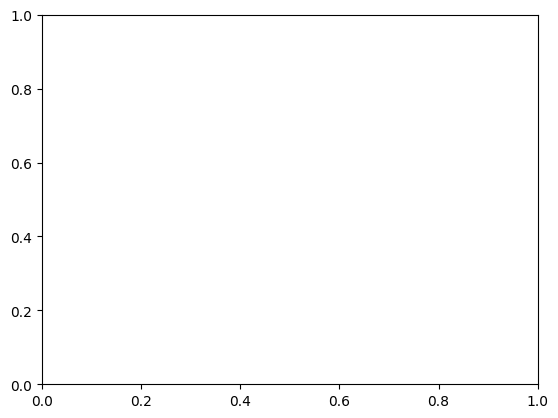

In [35]:
# Plotting the learning curve from the Monitor logs

# Helper function from Stable Baselines 3 to read monitor files
def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    # Smooth the curve using a moving average
    y = np.convolve(y, np.ones(100)/100, mode='valid')
    x = x[len(x) - len(y):]
    
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_results(LOG_DIR)

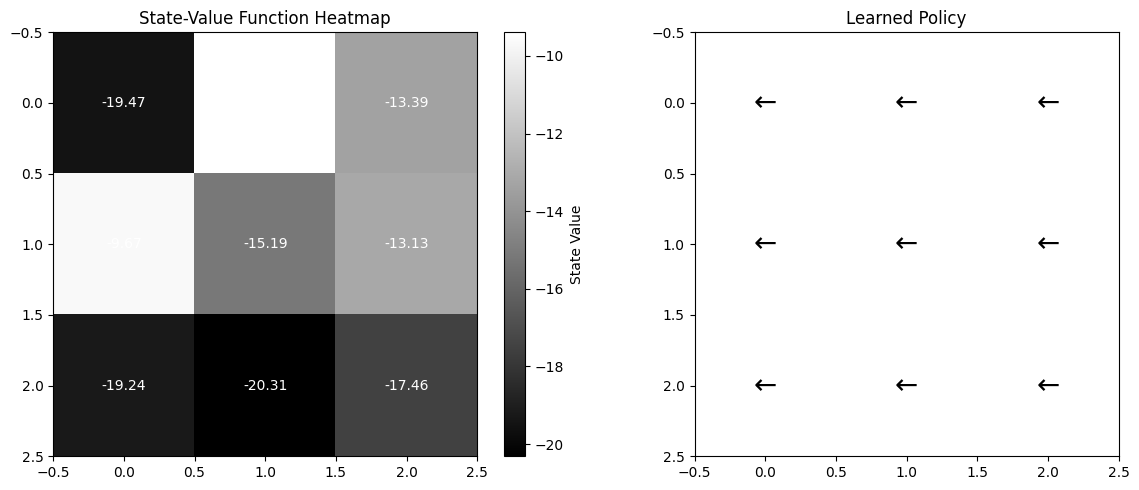

In [46]:
# Visualize the learned policy and value function
trained_model = PPO.load(f"trained_models/{save_model_name}")
grid_size = 3
policy_grid = np.zeros((grid_size, grid_size), dtype=int)
value_grid = np.zeros((grid_size, grid_size))

# Action mapping for arrows
# {0: LEFT, 1: DOWN, 2: RIGHT, 3: UP}
action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

for i in range(grid_size):
    for j in range(grid_size):
        obs = i * grid_size + j
        # Note: The observation must be an array for the model
        action, _ = trained_model.predict(np.array([obs]), deterministic=True)
        policy_grid[i, j] = action[0]
        
        # Get the value from the policy's value function
        # The observation needs to be preprocessed by the policy
        obs_tensor, _ = trained_model.policy.obs_to_tensor(np.array([obs]))
        value = trained_model.policy.predict_values(obs_tensor)
        value_grid[i, j] = value.item()

# Plot Value Function Heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(value_grid, cmap='gist_gray')
plt.title('State-Value Function Heatmap')
plt.colorbar(label='State Value')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{value_grid[i, j]:.2f}', ha='center', va='center', color='white')

# Plot Policy
plt.subplot(1, 2, 2)
plt.imshow(np.zeros_like(policy_grid), cmap='bone_r')
plt.title('Learned Policy')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, action_arrows.get(policy_grid[i, j], ' '), ha='center', va='center', color='black', fontsize=20)

plt.tight_layout()
plt.show()

## Notes
- Default timestep = 500 per run